<a href="https://colab.research.google.com/github/amrirasyidi/ztm_pytorch_learn/blob/main/coursera_Aerial_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
%%capture
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

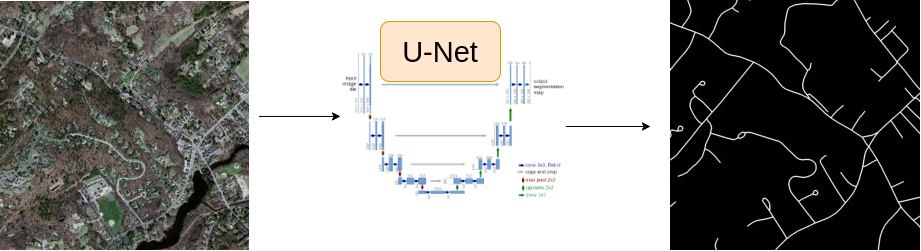

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 32.63 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [ ]:
import os
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = r"/content/Road_seg_dataset/train.csv"
DATA_DIR = r"/content/Road_seg_dataset"

DEVICE = 'cuda'

RANDOM_STATE = 42

EPOCHS = 25
LR = .003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx = 21

row = df.iloc[idx]

image_path = os.path.join(DATA_DIR, row.images)
mask_path = os.path.join(DATA_DIR, row.masks)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255

In [ ]:
# Set transparent pixels for 0 values in the mask
mask_rgba = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.float32)
mask_rgba[..., 3] = mask  # Set alpha channel based on mask values

# Set color to red for non-zero values
mask_rgba[mask != 0, :3] = [1, 0, 0]  # Set RGB values to red

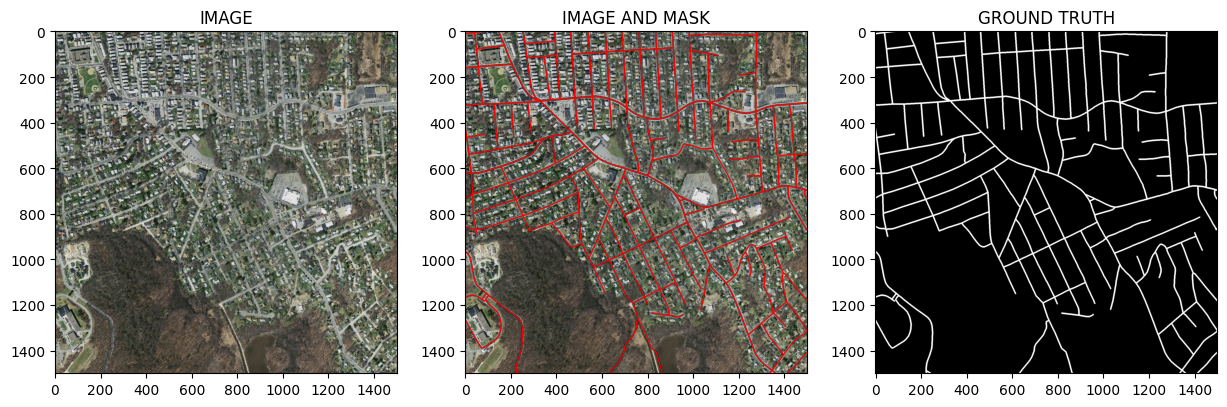

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('IMAGE AND MASK')
ax2.imshow(image)
ax2.imshow(mask_rgba)

ax3.set_title('GROUND TRUTH')
ax3.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = RANDOM_STATE)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

In [ ]:
get_train_augs()

Compose([
  Resize(always_apply=False, p=1, height=512, width=512, interpolation=1),
  HorizontalFlip(always_apply=False, p=0.5),
  VerticalFlip(always_apply=False, p=0.5),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = df.iloc[idx]

    image_path = os.path.join(DATA_DIR, row.images)
    mask_path = os.path.join(DATA_DIR, row.masks)

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  #(h,w,c)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  #(h,w)
    mask = np.expand_dims(mask, axis = -1)  #(h,w,c)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']  #(h,w,c)
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)  #(c,h,w)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)  #(c,h,w)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f'size of trainset: {len(trainset)}')
print(f'size of validset: {len(validset)}')

size of trainset: 159
size of validset: 40


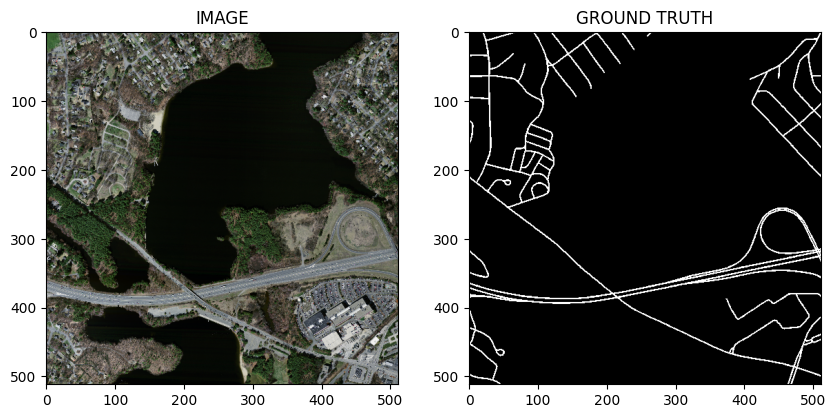

In [ ]:
idx = 99

image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f'Total no. of batches in trainloader: {len(trainloader)}')
print(f'Total no. of batches in validloader: {len(validloader)}')

Total no. of batches in trainloader: 20
Total no. of batches in validloader: 5


In [ ]:
for images, masks in trainloader:
  print(f'one batch IMAGE shape: {images.shape}')
  print(f'one batch MASK shape: {masks.shape}')
  break;

one batch IMAGE shape: torch.Size([8, 3, 512, 512])
one batch MASK shape: torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self, images, masks=None):
    logits = self.backbone(images)

    if masks!=None:
      return logits, DiceLoss(mode='binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 147MB/s]


SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(dataloader, model, optimizer):
  model.train() # Turn ON dropout, batchnorm, etc...

  total_loss = 0.0

  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)

In [ ]:
def eval_fn(dataloader, model):
  model.eval() # Turn OFF dropout, batchnorm, etc...

  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

    return total_loss/len(dataloader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_loss = np.Inf
data = []

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print("MODEL SAVED")
    best_loss = valid_loss

  epoch_data = {'epoch': i+1, 'train_loss': train_loss, 'valid_loss': valid_loss}
  data.append(epoch_data)

  print(f"epoch: {i+1} | Train Loss: {train_loss} | Valid Loss: {valid_loss}")


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


MODEL SAVED
epoch: 1 | Train Loss: 0.6559700071811676 | Valid Loss: 0.7002092242240906


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


MODEL SAVED
epoch: 2 | Train Loss: 0.6555310189723969 | Valid Loss: 0.6302978754043579


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


MODEL SAVED
epoch: 3 | Train Loss: 0.6470369398593903 | Valid Loss: 0.620891684293747


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


epoch: 4 | Train Loss: 0.6308761179447174 | Valid Loss: 0.6437559962272644


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


epoch: 5 | Train Loss: 0.6346232414245605 | Valid Loss: 0.6219554543495178


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


epoch: 6 | Train Loss: 0.6194825589656829 | Valid Loss: 0.6298285484313965


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


MODEL SAVED
epoch: 7 | Train Loss: 0.6081153869628906 | Valid Loss: 0.612170958518982


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


epoch: 8 | Train Loss: 0.6031262785196304 | Valid Loss: 0.6300313472747803


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


MODEL SAVED
epoch: 9 | Train Loss: 0.6049549654126167 | Valid Loss: 0.5897370755672455


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


epoch: 10 | Train Loss: 0.6067019298672676 | Valid Loss: 0.6377088785171509


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


epoch: 11 | Train Loss: 0.603539913892746 | Valid Loss: 0.6033130168914795


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


epoch: 12 | Train Loss: 0.6070473521947861 | Valid Loss: 0.6418507695198059


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


epoch: 13 | Train Loss: 0.6000758409500122 | Valid Loss: 0.6553481817245483


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


MODEL SAVED
epoch: 14 | Train Loss: 0.6064090847969055 | Valid Loss: 0.5757043123245239


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


MODEL SAVED
epoch: 15 | Train Loss: 0.5874375700950623 | Valid Loss: 0.5660651683807373


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


MODEL SAVED
epoch: 16 | Train Loss: 0.5766533687710762 | Valid Loss: 0.5645534634590149


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


epoch: 17 | Train Loss: 0.5763063415884971 | Valid Loss: 0.6012557804584503


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


epoch: 18 | Train Loss: 0.5782891869544983 | Valid Loss: 0.5661198854446411


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


MODEL SAVED
epoch: 19 | Train Loss: 0.5665853917598724 | Valid Loss: 0.5410190880298614


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


epoch: 20 | Train Loss: 0.5612260699272156 | Valid Loss: 0.5450430452823639


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


epoch: 21 | Train Loss: 0.5733128428459168 | Valid Loss: 0.6055488586425781


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


epoch: 22 | Train Loss: 0.567877072095871 | Valid Loss: 0.611176872253418


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


epoch: 23 | Train Loss: 0.5642877608537674 | Valid Loss: 0.5796358525753021


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


epoch: 24 | Train Loss: 0.5731929689645767 | Valid Loss: 0.5639855265617371


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

epoch: 25 | Train Loss: 0.5670887649059295 | Valid Loss: 0.5508784115314483


In [ ]:
history = pd.DataFrame(data)
history.head(3)

,epoch,train_loss,valid_loss
0,1,0.655970,0.700209
1,2,0.655531,0.630298
2,3,0.647037,0.620892


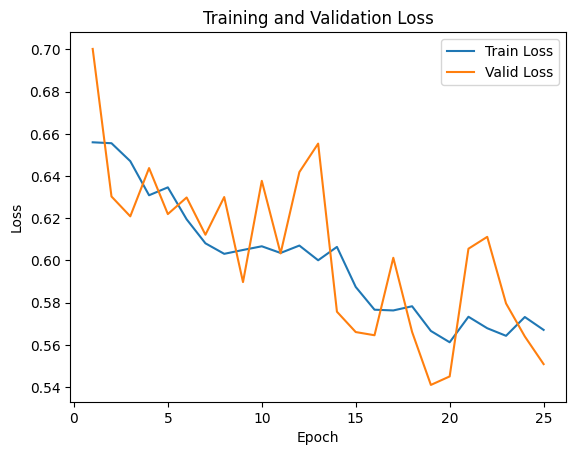

In [ ]:
plt.plot(history['epoch'], history['train_loss'], label='Train Loss')
plt.plot(history['epoch'], history['valid_loss'], label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Task 9 : Inference

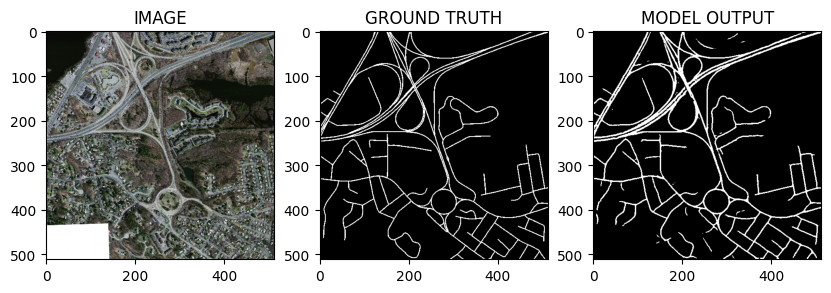

In [ ]:
idx = 2

model.load_state_dict(torch.load(os.path.join(os.getcwd(), 'best_model.pt')))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))  #unsqueeze: (c,h,w) -> (b, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

